# DATOS DE PRUEBA

In [4]:
import pandas as pd
import numpy as np

# Leer el archivo CSV
df = pd.read_csv("C:\\Users\\roesc\\Desktop\\hospital-efficiency-dashboard_data\\df_consolidado_final_v2.csv")

# Mostrar las primeras filas del DataFrame
df.head()

# pasar valores '--' a 0 en columnas 'Bienes y servicios' y 'Remuneraciones'
df['Bienes y servicios'] = df['Bienes y servicios'].replace('--', 0)
df['Remuneraciones'] = df['Remuneraciones'].replace('--', 0)

# pasar columnas de tipo string a tipo float
cols_to_float = ['Bienes y servicios', 'Remuneraciones']
for col in cols_to_float:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

# contar missing en las columnas usando pandas
missing_counts = df.isnull().sum()
# mostrar los conteos de valores faltantes
print(missing_counts)

# pasar missing a 0
df.fillna(0, inplace=True)

# contar missing en las columnas usando pandas
missing_counts = df.isnull().sum()
# mostrar los conteos de valores faltantes
print(missing_counts)

df_copy = df.copy()
df_2014 = df_copy[df_copy["Año"] == 2014]
df_2016 = df_copy[df_copy["Año"] == 2014]

# print shapes
print("Shape of original DataFrame:", df.shape)
print("Shape of 2014 DataFrame:", df_2014.shape)
print("Shape of 2016 DataFrame:", df_2016.shape)

hospital_id                    0
region_id                      0
hospital_name                  0
hospital_alternative_name      6
latitud                        0
longitud                       0
Consultas                      0
GRDxEgreso                   134
Bienes y servicios             0
Remuneraciones                 0
Dias Cama Disponibles          8
Consultas Urgencias            0
Examenes                       0
Quirofanos                     0
Año                            0
dtype: int64
hospital_id                  0
region_id                    0
hospital_name                0
hospital_alternative_name    0
latitud                      0
longitud                     0
Consultas                    0
GRDxEgreso                   0
Bienes y servicios           0
Remuneraciones               0
Dias Cama Disponibles        0
Consultas Urgencias          0
Examenes                     0
Quirofanos                   0
Año                          0
dtype: int64
Shape of origi

# FUNCIONES

## SFA

In [31]:
import numpy as np
import pandas as pd
from pysfa import SFA

def calculate_sfa_metrics(df: pd.DataFrame,
                          input_cols: list[str],
                          output_col: list[str],
                          te_threshold: float = 0.6,
                          fun: str = SFA.FUN_PROD,
                          method: str = SFA.TE_teJ) -> tuple[pd.DataFrame, dict]:
    """
    Ejecuta SFA sobre df y devuelve:
      - df_out: df con columna 'Eff_SFA'
      - metrics: diccionario con KPI y parámetros clave
    
    Parámetros:
    -----------
    df : DataFrame
      Datos con insumos y output.
    input_cols : lista de str
      Nombres de columnas de insumos.
    output_col : str
      Nombre de la columna de output.
    te_threshold : float
      Umbral para definir 'hospital crítico' (TE < te_threshold).
    fun : str
      Función a usar (SFA.FUN_PROD o FUN_COST).
    method : str
      Método de eficiencia (SFA.TE_teJ, TE_te, TE_teMod).
    
    Retorna:
    --------
    df_out : DataFrame
      df con la nueva columna 'Eff_SFA'.
    metrics : dict
      {
        'ET_promedio': float,      # eficiencia técnica promedio
        'pct_criticos': float,     # % de CRÍTICOS (TE < te_threshold)
        'variable_clave': str,     # insumo con β más alto y p<0.05
        'sigma2': float,           # varianza total del error
        'betas': np.ndarray,       # todos los β incl. intercept y λ
        'p_values': np.ndarray     # todos los p-values
      }
    """
    # 1) Ajuste del modelo SFA
    # seleccionar hospital_id y las columnas de inputs y outputs
    # df = df[['hospital_id'] + input_cols + output_col]

    # solo conservar las filas donde los inputs y outputs son mayores que 0
    df = df[(df[input_cols] > 0).all(axis=1) & (df[output_col] > 0).all(axis=1)]

    x = np.log(df[input_cols]).to_numpy()   # aplicar logaritmo a los inputs
    y = np.log(df[output_col]).to_numpy()   # aplicar logaritmo a los outputs

    sfa = SFA.SFA(y, x, fun=fun, method=method)
    sfa.optimize()
    
    # 2) Extraer eficiencia y añadirla
    te = np.array(sfa.get_technical_efficiency())
    df_out = df.copy()
    df_out['ET SFA'] = te
    
    # 3) Extraer parámetros
    all_betas = np.array(sfa.get_beta())     # [β0, β1..βk, λ]
    all_pvals = np.array(sfa.get_pvalue())
    sigma2    = sfa.get_sigma2()
    
    # 4) KPI: ET promedio y % críticos
    et_promedio = float(te.mean())
    pct_crit    = float((te < te_threshold).mean() * 100)
    
    # 5) Determinar variable clave
    k = len(input_cols)
    betas_in = all_betas[1:1+k]
    pvals_in = all_pvals[1:1+k]
    df_coef = pd.DataFrame({
        'input':   input_cols,
        'beta':    betas_in,
        'p_value': pvals_in
    })
    df_sign = df_coef[df_coef.p_value < 0.05].copy()
    if not df_sign.empty:
        df_sign['abs_beta'] = df_sign.beta.abs()
        var_clave = df_sign.sort_values('abs_beta', ascending=False).iloc[0].input
    else:
        var_clave = None
    
    # 6) Empaquetar métricas
    metrics = {
        'ET_promedio':    et_promedio,
        'pct_criticos':   pct_crit,
        'variable_clave': var_clave,
        'sigma2':         float(sigma2),
        'betas':          all_betas,
        'p_values':       all_pvals
    }

    # imprimir summary de sfa
    print(sfa.summary())
    
    return df_out, metrics

In [33]:
df_sfa, sfa_metrics = calculate_sfa_metrics(
    df=df_2014,
    input_cols=["Bienes y servicios", "Remuneraciones", "Dias Cama Disponibles"],
    output_col=["Quirofanos"],
    te_threshold=0.6
)

# Ejemplo de lectura de métricas:
print(f"Eficiencia promedio: {sfa_metrics['ET_promedio']:.2%}")
print(f"% críticos:         {sfa_metrics['pct_criticos']:.2f}%")
print(f"Variable clave:     {sfa_metrics['variable_clave']}")
print(f"Varianza σ²:        {sfa_metrics['sigma2']:.2f}")

             Parameters   Std.err  t-value  Pr(>|t|)
(Intercept)    -1.62991  4.392686   -0.371     0.712
x1             -0.72952  0.686884   -1.062     0.294
x2              0.96889  0.684144    1.416     0.163
x3              0.38926  0.362408    1.074     0.288
lambda          1.43487  1.044339    1.374     0.176
sigma2:  3.69256
sigmav2:  1.20717 ; sigmau2:  2.48539
log likelihood:  91.106
None
Eficiencia promedio: 33.42%
% críticos:         94.12%
Variable clave:     None
Varianza σ²:        3.69


## DEA

In [7]:
import numpy as np
import pandas as pd
from Pyfrontier.frontier_model import EnvelopDEA

def calculate_dea_metrics(df: pd.DataFrame,
                          input_cols: list[str],
                          output_cols: list[str],
                          orientation: str = "in",
                          rts: str = "CRS",
                          te_threshold: float = 0.6
                         ) -> tuple[pd.DataFrame, dict]:
    """
    Ejecuta un DEA y devuelve:
      - df_out: df con columna 'Eff_DEA'
      - metrics: {
          'ET_promedio': float,
          'pct_criticos': float,
          'variable_slack_clave': str,
          'rts': str,
          'orientation': str
        }
    
    Parámetros:
      df           : DataFrame con tus datos
      input_cols   : lista de nombres de columnas de insumos
      output_cols  : lista de nombres de columnas de outputs
      orientation  : 'in' o 'out'
      rts          : 'CRS' o 'VRS'
      te_threshold : umbral para % críticos (score < te_threshold)
    """
    df = df[(df[input_cols] > 0).all(axis=1) & (df[output_cols] > 0).all(axis=1)]

    # 1) Armar arrays
    x = df[input_cols].to_numpy()
    y = df[output_cols].to_numpy()
    
    # 2) Entrenar DEA
    dea_crs = EnvelopDEA(rts, orientation)
    dea_crs.fit(x, y)
    
    # 3) Scores y slacks
    scores_crs = np.array([res.score for res in dea_crs.result])
    # slacks: entrada [n_inputs x_slack_i] en res.x_slack
    slacks_crs = np.stack([res.x_slack for res in dea_crs.result], axis=0)  # shape (n, k)

    # 2) Entrenar DEA
    dea_vrs = EnvelopDEA(rts, orientation)
    dea_vrs.fit(x, y)
    
    # 3) Scores y slacks
    scores_vrs = np.array([res.score for res in dea_vrs.result])
    # slacks: entrada [n_inputs x_slack_i] en res.x_slack
    slacks_vrs = np.stack([res.x_slack for res in dea_vrs.result], axis=0)  # shape (n, k)
    
    # 4) DataFrame de salida
    df_out = df.copy()
    df_out["ET DEA"] = scores_crs
    
    # 5) KPI: promedio y críticos
    et_promedio = float(scores_crs.mean())
    pct_crit    = float((scores_crs < te_threshold).mean() * 100)
    
    # 6) Variable slack clave: el input cuyo slack medio es mayor
    mean_slacks = np.nanmean(np.where(slacks_crs==0, np.nan, slacks_crs), axis=0)
    idx_max     = int(np.nanargmax(mean_slacks))
    var_slack_clave = input_cols[idx_max]
    
    # 7) Calcular SE promedio
    se_ratio = np.where(scores_vrs == 0, np.nan, scores_crs / scores_vrs)
    se_promedio = float(np.nanmean(se_ratio))

    # 8) Empaquetar métricas
    metrics = {
        "ET_promedio":          et_promedio,
        "pct_criticos":         pct_crit,
        "variable_slack_clave": var_slack_clave,
        "se_promedio":          se_promedio,
        "orientation":          orientation,
        "rts":                  rts
    }
    return df_out, metrics


In [8]:
df_dea, dea_metrics = calculate_dea_metrics(
    df=df_2014,
    input_cols=["Bienes y servicios", "Remuneraciones", "Dias Cama Disponibles"],
    output_cols=["Consultas"],
    orientation="in",
    rts="CRS",
    te_threshold=0.6
)

print(f"ET Promedio:      {dea_metrics['ET_promedio']:.2%}")
print(f"% Hosp. críticos:  {dea_metrics['pct_criticos']:.2f}%")
print(f"Variable slack clave: {dea_metrics['variable_slack_clave']}")
print(f"SE Promedio:      {dea_metrics['se_promedio']:.2f}")

ET Promedio:      20.76%
% Hosp. críticos:  92.81%
Variable slack clave: Remuneraciones
SE Promedio:      1.00


## DEA-M

In [16]:
import numpy as np
import pandas as pd
from Pyfrontier.frontier_model import EnvelopDEA

def calculate_dea_malmquist(df_t, df_t1, input_cols, output_cols,
                            rts="CRS", orientation="in"):
    # 1) Recortar a índices comunes
    idx = df_t.index.intersection(df_t1.index)
    A_t  = df_t.loc[idx, input_cols + output_cols]
    A_t1 = df_t1.loc[idx, input_cols + output_cols]

    # 2) Entrenar fronteras completas
    X_t,  Y_t  = A_t[input_cols].to_numpy(),  A_t[output_cols].to_numpy()
    X_t1, Y_t1 = A_t1[input_cols].to_numpy(), A_t1[output_cols].to_numpy()

    dea_t  = EnvelopDEA(rts, orientation); dea_t.fit(X_t,  Y_t)
    dea_t1 = EnvelopDEA(rts, orientation); dea_t1.fit(X_t1, Y_t1)

    # 3) Scores en su propio periodo
    eff_t  = np.array([r.score for r in dea_t.result])
    eff_t1 = np.array([r.score for r in dea_t1.result])

    # 4) Cross‐efficiencies: re‐resolver DEA para cada DMU
    eff_t_on_t1  = []
    eff_t1_on_t  = []
    for x1, y1 in zip(X_t1, Y_t1):
        # Construye un pequeño dataset: todos los DMU de t + la DMU de t+1
        X_cross = np.vstack([X_t, x1[None,:]])
        Y_cross = np.vstack([Y_t, y1[None,:]])
        m = EnvelopDEA(rts, orientation); m.fit(X_cross, Y_cross)
        # El último resultado es la DMU “foránea”
        eff_t_on_t1.append(m.result[-1].score)
    for x0, y0 in zip(X_t, Y_t):
        X_cross = np.vstack([X_t1, x0[None,:]])
        Y_cross = np.vstack([Y_t1, y0[None,:]])
        m = EnvelopDEA(rts, orientation); m.fit(X_cross, Y_cross)
        eff_t1_on_t.append(m.result[-1].score)

    eff_t_on_t1  = np.array(eff_t_on_t1)
    eff_t1_on_t  = np.array(eff_t1_on_t)

    # 5) Malmquist y sus componentes
    effch = eff_t1 / eff_t
    tech  = np.sqrt((eff_t_on_t1/eff_t) * (eff_t1/eff_t1_on_t))
    malm  = effch * tech

    # 6) DataFrame de salida
    df_out = pd.DataFrame({
      "EFF_t":           eff_t,
      "EFF_t1":          eff_t1,
      "EFF_t_on_t1":     eff_t_on_t1,
      "EFF_t1_on_t":     eff_t1_on_t,
      "EFFCH":           effch,
      "TECH":            tech,
      "Malmquist":       malm
    }, index=idx)

    # 7) Resumen de medias
    summary = {
      "EFFCH_mean":     float(effch.mean()),
      "TECH_mean":      float(tech.mean()),
      "Malmquist_mean": float(malm.mean())
    }

    return df_out, summary

In [17]:
# Supón que df_2019 y df_2020 están indexados por hospital_id
df_malm, malm_summary = calculate_dea_malmquist(
    df_t        = df_2014,
    df_t1       = df_2016,
    input_cols  = ["Bienes y servicios", "Remuneraciones", "Dias Cama Disponibles"],
    output_cols = ["Consultas"]
)

print("Resumen Malmquist:")
print(malm_summary)
df_malm.head()

KeyboardInterrupt: 

## PCA

In [5]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple, Dict

def run_pca(df: pd.DataFrame,
            feature_cols: List[str],
            n_components: int | None = None,
            scale: bool = True
           ) -> Tuple[pd.DataFrame, Dict]:
    """
    Ejecuta PCA sobre las columnas `feature_cols` y devuelve:
      • df_pca  : DataFrame con columnas PC1, PC2, …, PCk
      • metrics : dict con varianza explicada y matriz de cargas
    
    Parámetros
    ----------
    df           : DataFrame original
    feature_cols : columnas a incluir en el PCA (solo numéricas)
    n_components : nº de componentes (None ⇒ tantas como variables)
    scale        : estandarizar variables a media 0 y σ 1 antes de PCA
    
    Ejemplo
    -------
    df_pca, meta = run_pca(df, ["slack_bs", "slack_rem", "slack_cama"], 2)
    """
    X = df[feature_cols].to_numpy(dtype=float)
    
    # Escalado opcional
    if scale:
        X = StandardScaler().fit_transform(X)
    
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(X)
    
    pc_cols = [f"PC{i+1}" for i in range(pcs.shape[1])]
    df_pca  = pd.DataFrame(pcs, index=df.index, columns=pc_cols)
    
    metrics = {
        "explained_variance_ratio": pca.explained_variance_ratio_.tolist(),
        "components": pd.DataFrame(pca.components_,
                                   index=pc_cols,
                                   columns=feature_cols)
    }
    return df_pca, metrics

Varianza explicada: [0.8832023361479518, 0.07553831704824703]

Matriz de cargas:
     Bienes y servicios  Remuneraciones  Dias Cama Disponibles  Consultas
PC1            0.507521        0.504668               0.499572   0.488017
PC2           -0.480097       -0.495250               0.395745   0.606317


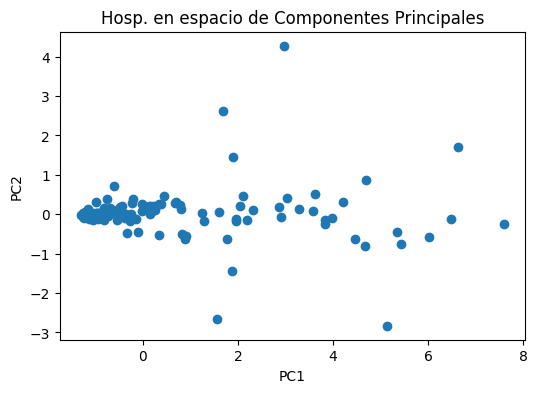

In [6]:
import matplotlib.pyplot as plt

# 1) Selecciona las columnas que quieres analizar
input_cols  = ["Bienes y servicios", "Remuneraciones", "Dias Cama Disponibles"]
output_cols = ["Consultas"]

# unir columnas en una sola lista
cols_pca = input_cols + output_cols

# 2) Ejecuta PCA (2 componentes para plot)
df_pca, pca_meta = run_pca(df_2014, cols_pca, n_components=2)

# 3) KPI rápidos
print("Varianza explicada:", pca_meta["explained_variance_ratio"])
print("\nMatriz de cargas:")
print(pca_meta["components"])

# 4) Ejemplo de visualización 2-D
plt.figure(figsize=(6,4))
plt.scatter(df_pca["PC1"], df_pca["PC2"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Hosp. en espacio de Componentes Principales")
plt.show()


## CLUSTERIZACIÓN

In [8]:
from typing import List, Tuple, Dict
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ------- usa la función run_pca que ya tienes --------
def pca_kmeans(df: pd.DataFrame,
               feature_cols: List[str],
               n_components: int = 2,
               k: int | None = None,
               k_max: int = 10,
               scale: bool = True,
               random_state: int = 42
              ) -> Tuple[pd.DataFrame, Dict]:
    """
    1) Ejecuta PCA con run_pca
    2) Aplica K-means (elige k óptimo con silhouette si k=None)
    3) Devuelve df con PCs y 'cluster', y un diccionario de metadatos
    """
    # ---- PCA --------------------------------------------------
    df_pca, pca_meta = run_pca(df, feature_cols,
                               n_components=n_components,
                               scale=scale)
    pc_cols = df_pca.columns.tolist()

    # ---- elegir k si no viene fijo ---------------------------
    if k is None:
        best_k, best_score = 2, -1
        for kk in range(2, k_max + 1):
            km = KMeans(n_clusters=kk, n_init="auto", random_state=random_state)
            labels = km.fit_predict(df_pca[pc_cols])
            score = silhouette_score(df_pca[pc_cols], labels)
            if score > best_score:
                best_k, best_score = kk, score
        k = best_k
        silhouette_best = best_score
    else:
        silhouette_best = None

    # ---- K-means definitivo -----------------------------------
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
    cluster_labels = kmeans.fit_predict(df_pca[pc_cols])

    # ---- ensamblar DataFrame de salida ------------------------
    df_out = df.copy()
    df_out = pd.concat([df_out, df_pca], axis=1)
    df_out["cluster"] = cluster_labels

    # ---- empaquetar metadatos ---------------------------------
    meta = {
        "explained_variance_ratio": pca_meta["explained_variance_ratio"],
        "components": pca_meta["components"],
        "k": k,
        "silhouette": silhouette_best,
        "cluster_centers": pd.DataFrame(kmeans.cluster_centers_,
                                        columns=pc_cols)
    }
    return df_out, meta

c:\Users\roesc\miniconda3\envs\python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\roesc\miniconda3\envs\python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\roesc\miniconda3\envs\python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\roesc\miniconda3\envs\python311\Lib\site-packages\sklearn\cluster\_kmeans.py:14

k elegido: 2
Varianza explicada: [0.8832023361479518, 0.07553831704824703]

Matriz de cargas:
     Bienes y servicios  Remuneraciones  Dias Cama Disponibles  Consultas
PC1            0.507521        0.504668               0.499572   0.488017
PC2           -0.480097       -0.495250               0.395745   0.606317


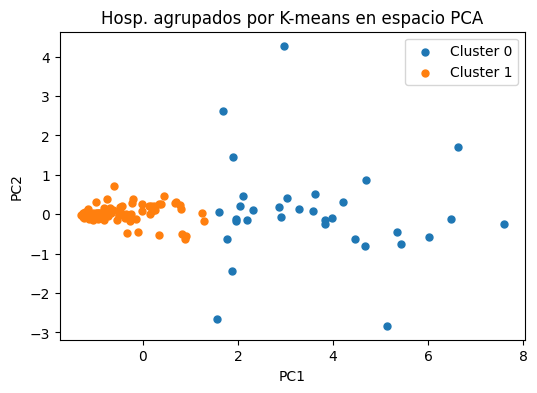

In [10]:
# columnas para el PCA
feature_cols = ["Bienes y servicios", "Remuneraciones",
                "Dias Cama Disponibles", "Consultas"]

df_cluster, info = pca_kmeans(df_2014,
                              feature_cols=feature_cols,
                              n_components=2,   # sólo PC1 y PC2
                              k=None,           # deja que la función elija
                              k_max=8)

print("k elegido:", info["k"])
print("Varianza explicada:", info["explained_variance_ratio"])
print("\nMatriz de cargas:")
print(info["components"])

# Visualizar
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
for cl in range(info["k"]):
    mask = df_cluster["cluster"] == cl
    plt.scatter(df_cluster.loc[mask, "PC1"],
                df_cluster.loc[mask, "PC2"],
                s=25, label=f"Cluster {cl}")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.title("Hosp. agrupados por K-means en espacio PCA")
plt.show()

## ANÁLISIS DE DETERMINANTES

In [ ]:
# deter_analysis.py
import pandas as pd
import numpy as np
import statsmodels.api as sm
from typing import List, Tuple, Dict

def determinant_analysis(df: pd.DataFrame,
                         dependent: str,
                         independents: List[str],
                         top_n: int = 5,
                         add_constant: bool = True
                        ) -> Tuple[pd.DataFrame, Dict]:
    """
    Ajusta un modelo OLS  y entrega la tabla de coeficientes + métricas resumidas.
    
    Parámetros
    ----------
    df          : DataFrame con los datos (sin nulos en cols usadas)
    dependent   : nombre de la columna dependiente (Y)
    independents: lista de columnas explicativas (X)
    top_n       : nº de determinantes "clave" a destacar
    add_constant: añade intercepto si True
    
    Devuelve
    --------
    coef_table : DataFrame con coef, std_err, t, p
    meta       : dict  {
                         'r2'           : float,
                         'r2_adj'       : float,
                         'top_vars'     : list[str]
                       }
    """
    # 0) Filtrar filas completas
    df_clean = df.dropna(subset=[dependent] + independents).copy()

    # 1) Matrices
    y = df_clean[dependent].astype(float).to_numpy()
    X = df_clean[independents].astype(float)
    if add_constant:
        X = sm.add_constant(X)
    
    # 2) Ajustar modelo
    model = sm.OLS(y, X).fit()
    
    # 3) Tabla de coeficientes
    coef_table = model.summary2().tables[1]                 # coef, std err, t, P>|t|
    coef_table.index.name = "variable"
    coef_table.reset_index(inplace=True)
    
    # 4) Variables “clave”  (|coef| grande & p<0.05)
    sig = coef_table[coef_table["P>|t|"] < 0.05].copy()
    sig["abs_coef"] = sig["Coef."].abs()
    sig_sorted = sig.sort_values("abs_coef", ascending=False)
    top_vars = sig_sorted["variable"].head(top_n).tolist()
    
    # 5) Métricas de resumen
    meta = {
        "r2":      model.rsquared,
        "r2_adj":  model.rsquared_adj,
        "top_vars": top_vars
    }
    return coef_table, meta


In [ ]:
coef_tbl, info = determinant_analysis(
    df           = df_sample,
    dependent    = "Eff_DEA",              # o el KPI que quieras explicar
    independents = ["Bienes y servicios",
                    "Remuneraciones",
                    "Días Cama Disponibles",
                    "Consultas"],
    top_n        = 3
)

print("R²:", info["r2"]:.3f, "  –  R² ajustado:", info["r2_adj"]:.3f)
print("Determinantes clave:", info["top_vars"])
display(coef_tbl)


SyntaxError: invalid decimal literal (4261970792.py, line 11)